In [2]:
import math
import time
import json
import scipy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from numpy import cos, sin, arcsin, sqrt
%matplotlib inline
plt.figure(figsize=(20,5))
PALETTE = ["#FFC30D", "#EF404B"]
PALETTE_ALT = ["#40EFE4", "#EF404B"]
PALETTE_DEG = ["FF"]

<Figure size 1440x360 with 0 Axes>

In [10]:
df = pd.read_pickle('../data/shippify_icd_new.pkl', compression='gzip')
df = df.dropna(subset=['pickup_effective_dt', 'delivery_effective'])
#df.info()

### **Agregar codigo necesario debajo de su nombre**

## Enmanuel Magallanes

In [11]:
def set_labels(title=None, x_label=None, y_label=None, fontsize=14, legend=None):
  if title is not None:
    plt.title(title, fontsize=fontsize)
  if x_label is not None:
    plt.xlabel(x_label, fontsize=fontsize)
  if y_label is not None:
    plt.ylabel(y_label, fontsize=fontsize)
  if legend is not None:
    legend['object'].set_title(legend['title'])
    for t, l in zip(legend['object'].texts, legend['texts']): t.set_text(l)

def with_hue(plot, feature, categories, hue_categories, diff=False):
  a = [p.get_height() for p in plot.patches]
  patch = [p for p in plot.patches]
  differences = {'class': [], 'value': []}
  for i in range(categories):
    total = a[i] + a[i+categories]
    difference = []
    for j in range(hue_categories):
      value = round(100 * a[(j*categories + i)]/total, 2)
      percentage = '{:.1f}%'.format(value)
      x = patch[(j*categories + i)].get_x() + patch[(j*categories + i)].get_width() / 2 - 0.15
      y = patch[(j*categories + i)].get_y() + patch[(j*categories + i)].get_height() 
      plt.annotate(percentage, (x, y), size = 12)
      if diff:
        difference.append(value)
    if diff:
      diff_value = abs(round(difference[0]-difference[1], 2))
      differences['class'].append(feature[i])
      differences['value'].append(diff_value)
      print('{0:16s}: |{1:>5} - {2:>5}| = {3:>5}'.format(feature[i], difference[0], difference[1], diff_value))
    #print(f'{feature[i]}: {difference[0]} - {difference[1]} = {abs(round(difference[0]-difference[1], 2))}')
  plt.show()
  if diff:
    return pd.DataFrame.from_dict(differences)
  
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

## Question: Is the total weight of packages a factor affecting the timeliness of deliveries?

In [14]:
def sum_total_weight(row):
  items = json.loads(row)
  total_weight = 0
  for item in items:
    try:
      weigth = item['weight']
      if weigth == 'NaN':
        total_weight += 0
      else:
        total_weight += float(weigth)
    except:
      total_weight += 0
  return total_weight
df['total_weight'] = df['items'].apply(sum_total_weight)

In [15]:
# Remove outlayers using the z-score
z_scores = stats.zscore(df['total_weight'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df = df[ filtered_entries ]

labels = ['[0,0.5) kg', '[0.5,1) kg', '[1,1.5) kg', '[1.5,2) kg', '[2,2.5) kg', '[2.5,3) kg', '[3,3.5) kg', '[3.5 kg,inf) kg']
#df['class_weight'] = pd.cut(df['total_weight'], bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, np.inf], labels=labels, include_lowest=True)

In [ ]:
#Rename type of size packages to be more readable
size_dict = { 1: 'X Small', 2: 'Small', 3: 'Medium', 4: 'Large', 5: 'X Large' }
df['total_size'] = df['total_size'].apply(lambda size: size_dict.get(size, 3))

#Add column with total of task in this city
df['total_task'] = len(df)

# Add column to mark task that was deliveried with delay
df['is_late'] = df['delivery_dt'] < df['delivery_effective']

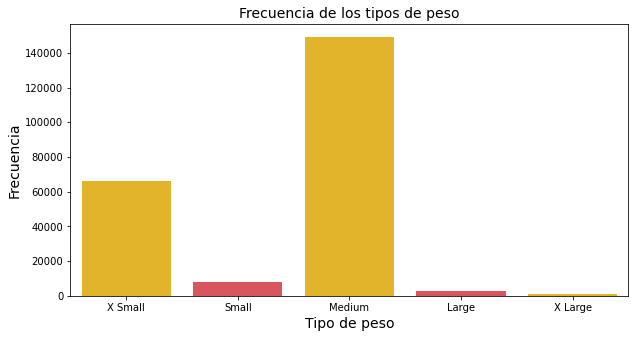

In [162]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='total_size', order=size_dict.values(), palette=PALETTE)
set_labels('Frecuencia de los tipos de peso', 'Tipo de peso', 'Frecuencia')

X Small         : |45.86 - 54.14| =  8.28
Small           : |49.41 - 50.59| =  1.18
Medium          : |23.47 - 76.53| = 53.06
Large           : |13.29 - 86.71| = 73.42
X Large         : |31.04 - 68.96| = 37.92


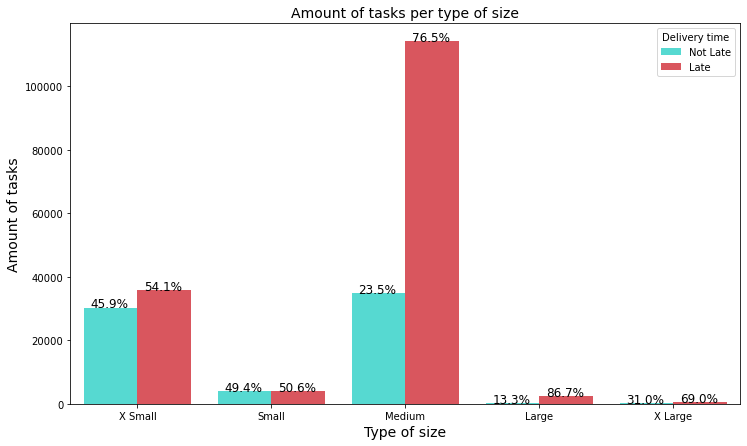

In [250]:
gsl = df[['id', 'total_size', 'is_late']].groupby(['total_size', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gsl, x='total_size', y='id', hue='is_late', order=size_dict.values(), palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per type of size', 'Type of size', 'Amount of tasks', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
diff_size = with_hue(f, list(size_dict.values()), 5, 2, diff=True)

In the graph we can see that there are more deliveries with size X Small and Medium than the others. However, what is important here is to analyze the percentage of tasks delivered on time and those that are not. There are no significant differences between Small and Small X-size tasks. In contrast, Medium, Large and X Large tasks have a significant difference in the percentage of on-time deliveries. This indicates that the size of deliverables affects on-time delivery when their size is equal to or larger than Medium.

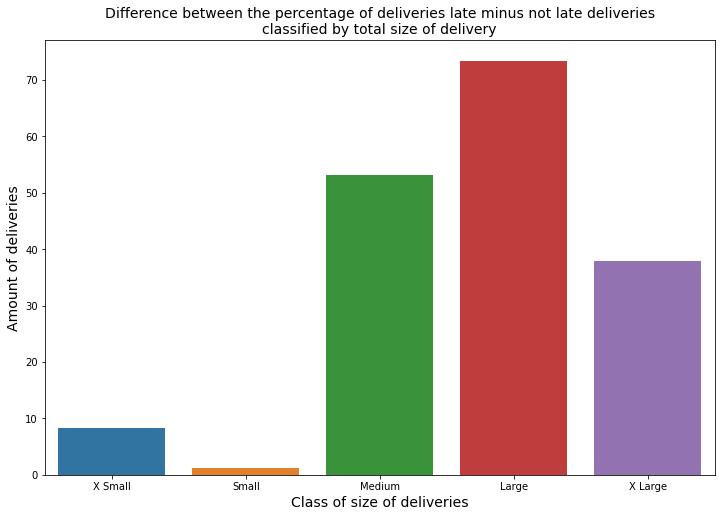

In [253]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_size, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by total size of delivery',
  x_label='Class of size of deliveries', y_label='Amount of deliveries'
)

### Question 3: Are tasks with fewer neighboring deliveries* taking longer to reach their delivery point?
\* We define neighboring deliveries as all those deliveries that are less than or equal to X KM away from the same and their delivery date is within T hours of the same.

In [21]:
# We will group deliveries by route ID, to get the average distance and time from the first delivery to the last delivery. 
# With these values we will obtain distance and time ranges to find the route density.
def haversine_distance(x, y):
  lon1, lat1, lon2, lat2 = map(math.radians, [x[0], x[1], y[0], y[1]])
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
  c = 2 * math.asin(sqrt(a))
  return R * c

def generate_combinations(points):
  combinations = []
  for i in range(len(points)):
    for j in range(i+1, len(points)):
      combinations.append([points[i], points[j]])
  return combinations

def calculate_time(group):
  min_dt = group['delivery_dt'].min()
  max_dt = group['delivery_dt'].max()
  return (max_dt - min_dt).total_seconds() / 3600

def calculate_distance(group):
  group = group.set_index('delivery_dt')
  group = group.sort_values('delivery_dt')
  center = (group['long'].mean(), group['lat'].mean())
  return np.array(group.apply(lambda r: haversine_distance((r.long, r.lat), center), axis=1)).mean()

In [ ]:
gr_hours = df.groupby('route_id').apply(calculate_time)
gr_distance = df.groupby('route_id').apply(calculate_distance)

Mean time from first delivery to the last delivery: 3.12 hours


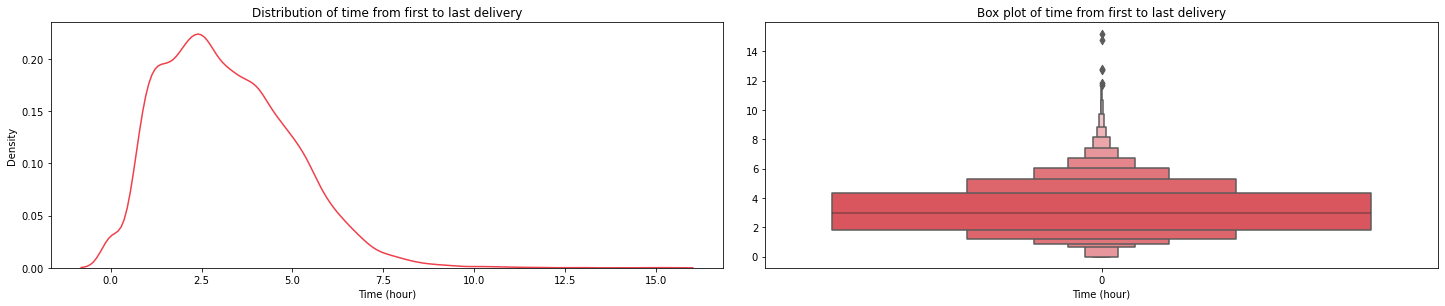

In [141]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of time from first to last delivery')
ax[0].set_xlabel('Time (hour)')
sns.kdeplot(data=gr_distance, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of time from first to last delivery')
ax[1].set_xlabel('Time (hour)')
sns.boxenplot(data=gr_distance, ax=ax[1], color=PALETTE[1])

print('Mean time from first delivery to the last delivery: {0:.2f} hours'.format(gr_hours.mean()))

Mean distance first delivery to the last delivery: 3.20 km


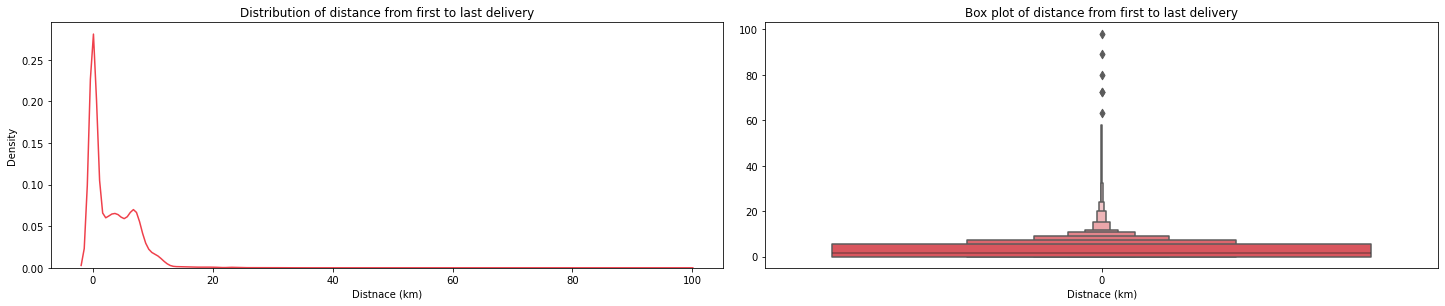

In [144]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of distance from first to last delivery')
ax[0].set_xlabel('Distnace (km)')
sns.kdeplot(data=gr_hours, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of distance from first to last delivery')
ax[1].set_xlabel('Distnace (km)')
sns.boxenplot(data=gr_hours, ax=ax[1], color=PALETTE[1])
print('Mean distance first delivery to the last delivery: {0:.2f} km'.format(gr_distance.mean()))

As we can see the scheduled time from the first delivery to the last delivery, on average, is 3.12 hours and the distance, on average, is 3.20 km. These values will be our time window and radius to use to determine the number of deliveries that exist around one

In [ ]:
def task_around(row, inner):
  diffs = (row['delivery_dt'] - inner['delivery_dt'])
  diffs = np.abs(diffs.dt.total_seconds()) / 3600
  inner = inner[ diffs <= WINDOW_TIME ]
  distances = inner.apply(
    lambda pt: haversine_distance((pt['long'], pt['lat']), (row['long'], row['lat'])),
    axis=1
  )
  return len(inner[ distances <= KMS_AROUND ])

R = 6371
KMS_AROUND = 3.20
WINDOW_TIME = 3.12
task_around = df.apply(lambda r: task_around(r, df.copy()), axis=1)

In [150]:
df['task_around'] = task_around

In [244]:
df['class_neighboring'] = pd.cut(
  df['task_around'], 
  include_lowest=True,
  bins=[x for x in range(0, 800, 100)]
)
#df_filtered['class_neighboring'] = df_filtered['class_neighboring'].astype('str')

In [172]:
# Remoiving outlayers using the z-score
z_scores = stats.zscore(df['task_around'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df_filtered = df[ filtered_entries ]

Mean neighboring deliveries: 167.37 deliveries
STD neighboring deliveries: 139.15


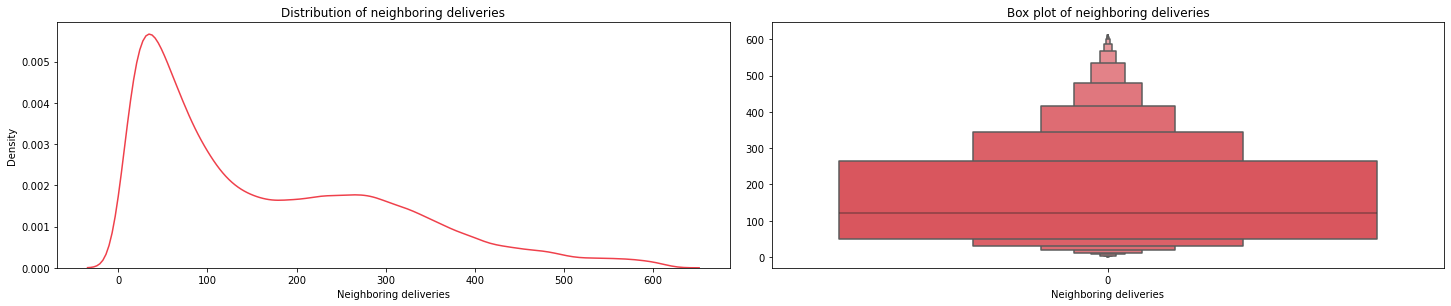

In [170]:
fig, ax =plt.subplots(1,2, figsize=(20,4))
fig.tight_layout()

ax[0].set_title('Distribution of neighboring deliveries')
ax[0].set_xlabel('Neighboring deliveries')
sns.kdeplot(data=task_around_filtered, ax=ax[0], color=PALETTE[1])

ax[1].set_title('Box plot of neighboring deliveries')
ax[1].set_xlabel('Neighboring deliveries')
sns.boxenplot(data=task_around_filtered, ax=ax[1], color=PALETTE[1])

print('Mean neighboring deliveries: {0:.2f} deliveries'.format(task_around_filtered.mean()))
print('STD neighboring deliveries: {0:.2f}'.format(task_around_filtered.std()))

(-0.001, 100.0] : |41.61 - 58.39| = 16.78
(100.0, 200.0]  : |28.14 - 71.86| = 43.72
(200.0, 300.0]  : |24.59 - 75.41| = 50.82
(300.0, 400.0]  : |18.32 - 81.68| = 63.36
(400.0, 500.0]  : |11.01 - 88.99| = 77.98
(500.0, 600.0]  : | 5.26 - 94.74| = 89.48
(600.0, 700.0]  : |  5.0 -  95.0| =  90.0


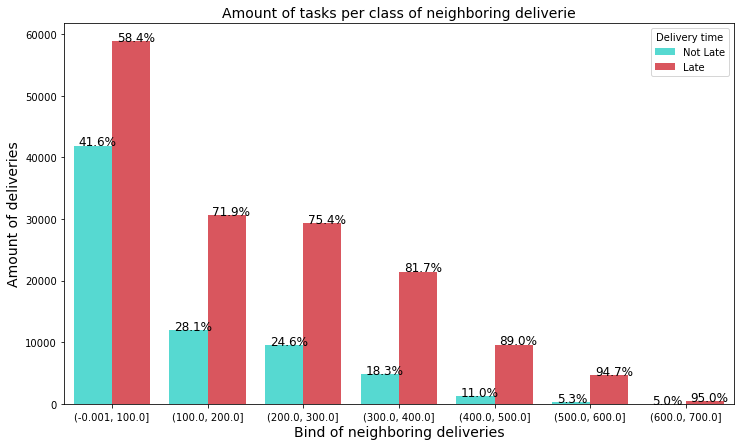

In [248]:
gnl = df_filtered[['id', 'class_neighboring', 'is_late']].groupby(['class_neighboring', 'is_late'])['id'].count().reset_index()
plt.figure(figsize=(12,7))
plt.tight_layout()
f = sns.barplot(data=gnl, x='class_neighboring', y='id', hue='is_late', palette=PALETTE_ALT)

set_labels(
  'Amount of tasks per class of neighboring deliverie', 'Bind of neighboring deliveries', 'Amount of deliveries', 
  legend={'object': f.get_legend(), 'title': 'Delivery time', 'texts': ['Not Late', 'Late']
})
classes_list = df_filtered['class_neighboring'].sort_values().unique()
diff_list = with_hue(f, classes_list, 7, 2, diff=True)

In the plot we can see that as the number of neighboring deliveries increases, the percentage of late deliveries also increases. This tells us that the higher the concentration or density of deliveries around you, the more likely it is that you will be late in reaching the final customer

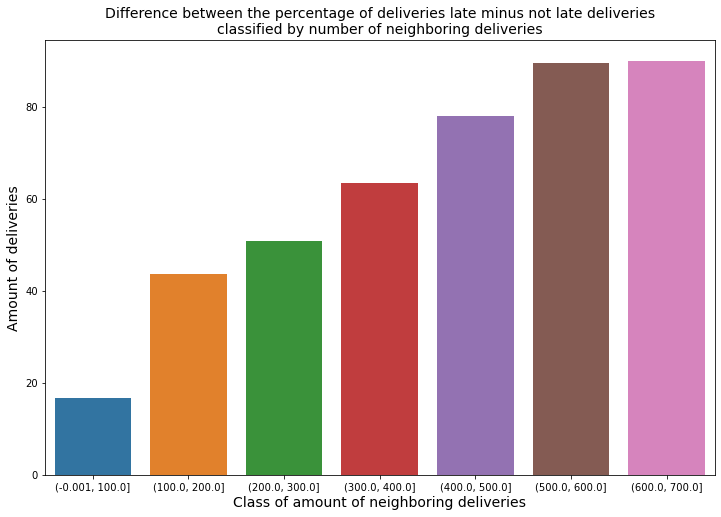

In [249]:
plt.figure(figsize=(12,8))
plt.tight_layout()
sns.barplot(data=diff_list, x='class', y='value')
set_labels(
  title='Difference between the percentage of deliveries late minus not late deliveries\nclassified by number of neighboring deliveries',
  x_label='Class of amount of neighboring deliveries', y_label='Amount of deliveries'
)

In [246]:
#df.to_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')

### Hour late vs Total weight

In [31]:
diff = df['delivery_dt'] - df['delivery_effective']
df['delay_delivery'] = diff.apply(lambda x: abs(int(x.total_seconds()))) / 3600

In [ ]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')

In [ ]:
def get_color(tasks):
  """Get color for task"""
  if tasks == 0:
    return 'black'
  elif 0 <= tasks < 300:
    return 'blue'
  elif 300 <= tasks < 1000:
    return 'red'

def add_marker(row, map_stg):
  folium.Marker(
    location=[row['lat'], row['long']],
    popup=row['id'],
    icon=folium.Icon(color=get_color(row['task_around']))
  ).add_to(map_stg)

In [ ]:
stg_map = folium.Map(location=[-33.469477, -70.643929], zoom_start=12)
a = df \
[['lat', 'long', 'id', 'class_neighboring', 'task_around']].sample(200).apply(
  lambda r: add_marker(r, stg_map), axis=1
)
#[ (df['task_around']>=400) & (df['task_around']<800) ] \

In [ ]:
df_t = df.copy()

In [ ]:
df_t['hight_neight'] = np.where((df['task_around'] >= 300) & (df['task_around'] <= 1000), 1, 0)

In [ ]:
plt.figure(figsize=(12,10))
plt.tight_layout()
sns.scatterplot(data=df_t[['hight_neight', 'lat', 'long']], x='lat', y='long', hue='hight_neight').set(xlim=(-33.7,-33.2), ylim=(-70.4,-70.95))

## Josue Cobos

### Question 4: Are those deliveries that are further from the economic center of Santiago de Chile those with the longest delivery delay?

In [ ]:
####For response we will assume that "Comuna Santiago" is the economic center of Santiago

In [32]:
#For this question we will assume Barreiro in the most important regional administration of Belo Horizonte
COMUNASANTIAGO = (-33.452618, -70.666634)
def getDistanceFromCenter(row):
  return haversine_distance(COMUNASANTIAGO, (row['lat'], row['long']))

In [33]:
df['dst_to_ec_center'] = df[['lat', 'long']].apply(getDistanceFromCenter, axis=1)

In [37]:
z_scores = stats.zscore(df['dst_to_ec_center'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df_filtered = df[ filtered_entries ]

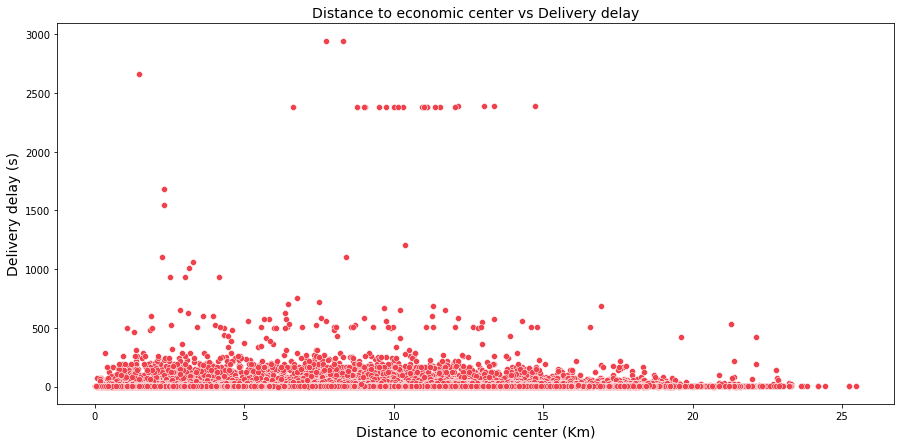

In [40]:
plt.figure(figsize=(15,7))
subdf = df_filtered[['dst_to_ec_center','delay_delivery']]
f2 = sns.scatterplot(x=subdf['dst_to_ec_center'], y=subdf['delay_delivery'], color=PALETTE[1])
set_labels(
  title='Distance to economic center vs Delivery delay',
  x_label='Distance to economic center (Km)', y_label='Delivery delay (s)'
)

In [39]:
subdf.corr()

,dst_to_ec_center,delay_delivery
dst_to_ec_center,1.000000,0.011712
delay_delivery,0.011712,1.000000


In [ ]:
#Answer: Due to the non-existent correlation between the delay of shipments (delay_delivery) and distance to economic center (dst_to_ec_center), we can conclude that no matter how far your order is, it does not necessarily mean that it has a longer delay time.

### Question 2: Does the intensity of traffic at the destination point of a delivery influence the timeliness of the delivery?

In [ ]:
locationDf = pd.read_json('../Traffict/jobs_2345752_results_ICD_STG.json')